In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from joblib import dump, load

import networkx as nx
from node2vec import Node2Vec
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import hamming, dice
from sklearn.manifold import TSNE

The targeted graph dataset is actor co-occurrence network. Each node corresponds to an actor, and the edge between two nodes denotes co-occurrence on the same Wikipedia page. Node features correspond to the presence of some keywords in the Wikipedia pages.

Edges have been deleted at random from a graph. Your mission is to accurately reconstruct the initial network using both graph-theoretical and node feature information.

In this competition, we define an actor network where nodes represent actors and edges between two nodes stand for co-occurrence on the same Wikipedia page. This is a proxy for their joint participation in the same movie, for their personal relation, for their level of fame, etc.

In addition to the graph structure, each node (i.e., actor) is also associated with textual information processed from its Wikipedia page, from which some keywords were extracted. Only the processed features are available here.

Your goal is to utilize information from both the underlying actor network and the processed Wikipedia description in order to accurately predict missing edges.

Files : 

- train.txt : the training set, which consists in 10k labeled node pairs (1 if there is an edge between the two nodes, 0 else). Non-edges (with label 0) were randomly added, they are not part of the original graph. There is one pair and label per row, written as: source node ID, target node ID, and 1 or 0. The IDs match the papers in the node_information.csv file (see below).

- test.txt : the test set with 3498 node pairs. There is one pair per row, as: source node ID, target node ID. You need to predict if these node pairs were edges in the original graph (label 1), or not (0).

- node_information.csv : 932 features for each node (e.g. actor), representing an encoding of the textual information of each actor's wikipedia page. The first column denotes the node index, there is no headers.

#### References

##### Graph Neural Networks: Link Prediction - Muhan Zhang

There are mainly three types of traditional link prediction methods: `heuristic methods`, `latent-feature methods`, and `content-based methods`.

- Heuristic methods compute heuristic node similarity scores as the likelihood of links (common neighbors, Adamic-Adar, preferential attachment, Katz index ...)

    - `Common neighbors` $f_{CN}(x,y)=|\Gamma (x) \cap \Gamma (y)|$ : counts the number
of neighbors two nodes share 

    - `Jaccord score` measures the proportion of common neigbors $f_{Jaccard} (x,y) = \frac{|\Gamma (x) \cap \Gamma (y)|}{|\Gamma (x) \cup \Gamma (y)|}$

    - `Preferential attachment` which uses the product of node degrees: $f_{PA} (x,y)=|\Gamma (x)|•|\Gamma (y)|$ e.g x is more likely to connect to y if y has a high degree (networks formed by the PA mechanism are called scale-free networks)

    - `Adamic-Adar` considers the weight of common neighbors $f_{AA} (x,y)= \sum _{z \in \Gamma (x) \cap \Gamma (y)} \frac{1}{\log |\Gamma (z)|}$ (the assumption is that a high degree node connecting to both x and y is less informative than a low-degree node). This is a second-order heuristic (two hops of neighbors are required). See `Resource allocation` that uses a more aggressive down- weighting factor.

    - High-order heurisitcs (require knowing the entire network) are `Katz index` (weighted sum of all the walks between x and y where a longer walk is discounted more), `Rooted PageRank` (generalization of PageRank) and `SimRank` score (assumes that two nodes are similar if their neighbors are also similar)

- Latent-feature methods factorize the matrix representations of a network to learn low-dimensional latent representations/embeddings of nodes (embedding techniques such as DeepWalk, LINE, node2vec). 

Both heuristic methods and latent-feature methods infer future/missing links leveraging the existing network topology.

- Content-based methods, on the contrary, leverage explicit node attributes/features (rather than graph structure).

`Combining the graph topology with explicit node features can improve the link prediction performance : this is the case with GNN`

There are two popular GNN-based link prediction paradigms: `node-based` (first learn a node representation through a GNN, and then aggregate the pairwise node representations as link representations for link prediction e.g VGAE) and `subgraph-based` (first extract a local subgraph around each target link, and then apply a graph-level GNN (with pooling) to each subgraph to learn a subgraph representation, which is used as the target link representation for link prediction e.g SEAL).

- Node-based method

    - `VGAE` (variational graph auto-encoder): this model makes use of latent variables and is capable of learning interpretable latent representa- tions for undirected graphs. We are given an undirected, unweighted graph G = (V,E) with N = |V| nodes. We introduce an adjacency matrix A of G (we assume diagonal elements set to 1, i.e. every node is connected to itself) and its degree matrix D. We further introduce stochastic latent variables zi, summarized in an N × F matrix Z. Node features are summarized in an N × D matrix X.

The theoretical analysis of labeling trick (Zhang et al, 2020c) proves that subgraph-based approaches have a higher link representation power than node-based approaches by being able to learn most expressive structural representations of links.

#### Data Loading

In [2]:
node_info = pd.read_csv('data/node_information.csv', header=None)
node_info = node_info.set_index(0)

In [3]:
def load_graph_from_file(file_path):
    """Load graph from edge list file."""
    df = pd.read_csv(file_path, sep=" ", header=None, names=['source', 'target', 'label'])
    G = nx.from_pandas_edgelist(df[df['label'] == 1], 'source', 'target', create_using=nx.Graph())
    return G, df

In [4]:
G, data = load_graph_from_file('data/train.txt')  # Adjust the file path

#### Preprocessing

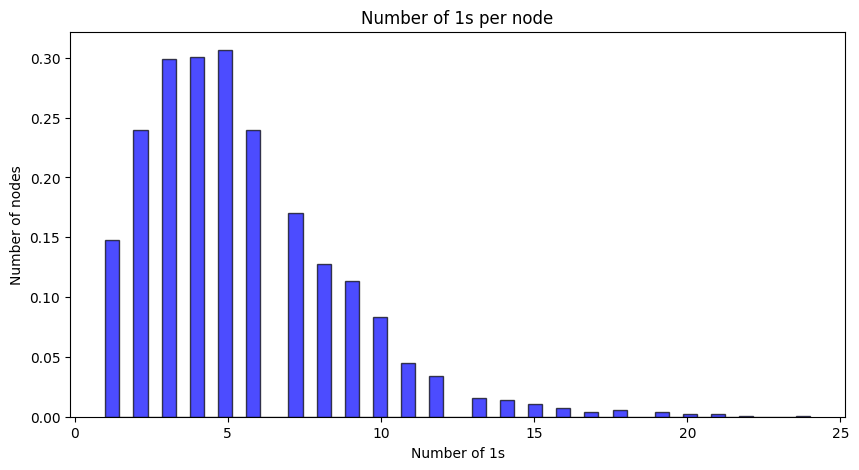

In [28]:
sum_of_ones_per_node = node_info.sum(axis=1)

plt.figure(figsize=(10, 5))
plt.hist(sum_of_ones_per_node, bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)
plt.xlabel('Number of 1s')
plt.ylabel('Number of nodes')
plt.title('Number of 1s per node')
plt.show()

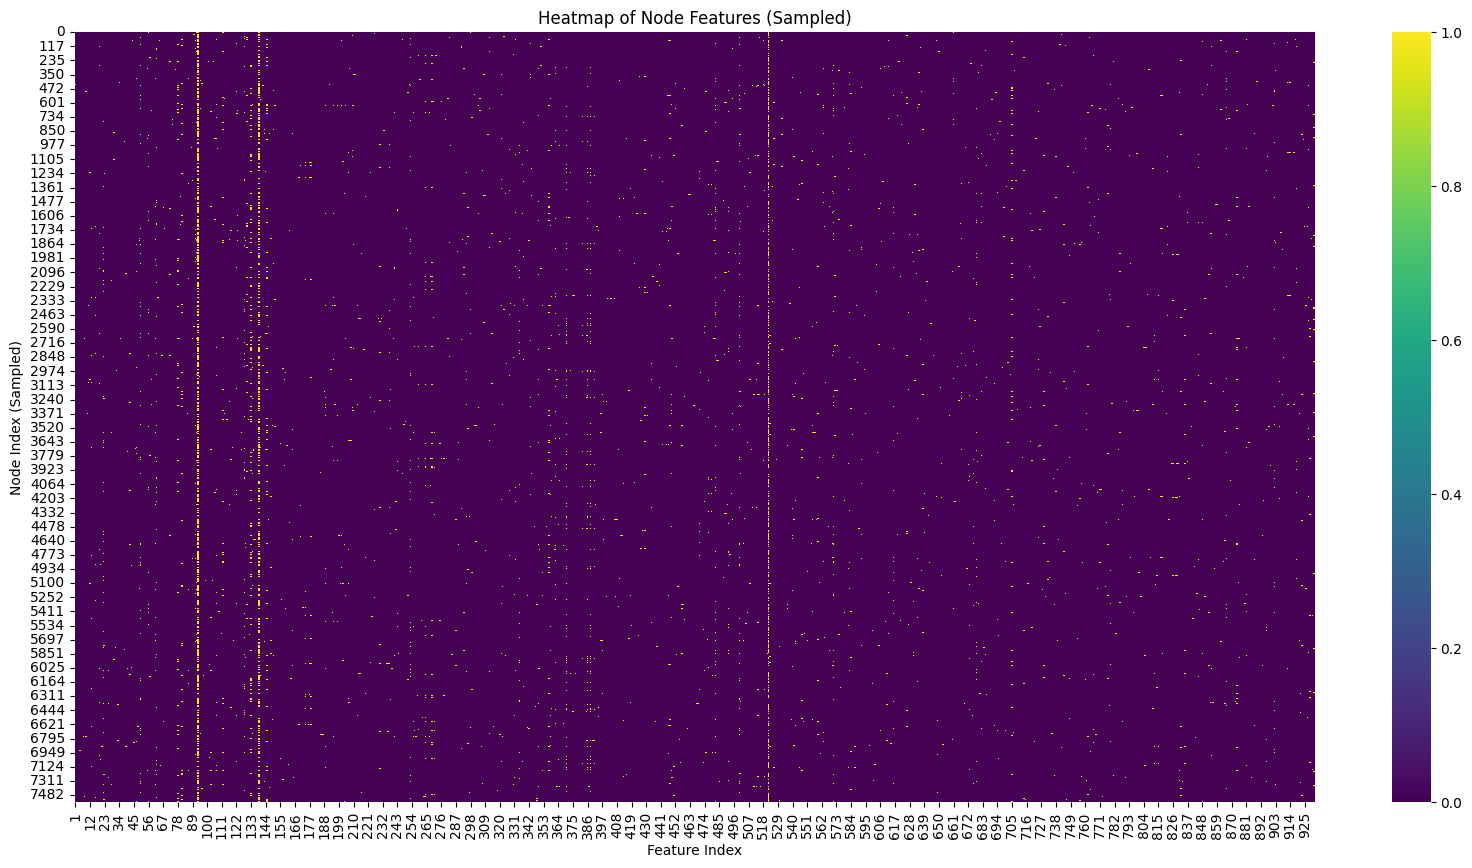

In [158]:
import seaborn as sns

# Plotting a heatmap of the node features
# For large datasets, consider sampling or aggregating to avoid performance issues
plt.figure(figsize=(20, 10))
sns.heatmap(node_info, cmap='viridis', cbar=True)
plt.title('Heatmap of Node Features (Sampled)')
plt.xlabel('Feature Index')
plt.ylabel('Node Index (Sampled)')
plt.show()


/var/folders/b5/h5wp64956x7cjclt5wgp03qm0000gn/T/ipykernel_22204/2332792449.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(node_info_reduced[:, 0], node_info_reduced[:, 1], cmap='viridis')


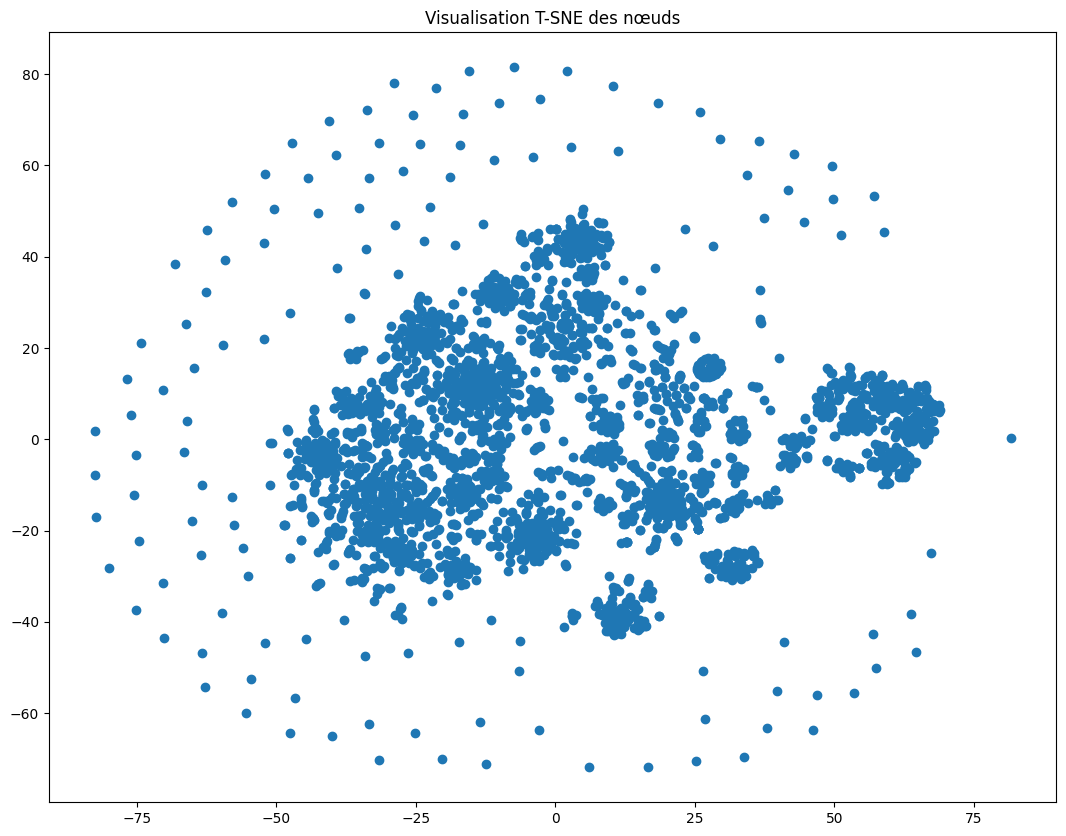

In [46]:
numerical_features = node_info.select_dtypes(include=[np.number])

# Utilisation de T-SNE pour réduire la dimensionnalité à 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
node_info_reduced = tsne.fit_transform(numerical_features)

plt.figure(figsize=(13,10))
plt.scatter(node_info_reduced[:, 0], node_info_reduced[:, 1], cmap='viridis')
plt.title('Visualisation T-SNE des nœuds')
plt.show()

Are the source and target nodes connected? 1
Number of 1s in source node: 9.0
Number of 1s in target node: 1.0
Indice of 1s in source node: [ 21  26  73  92 354 521 566 728 835]
Indice of 1s in target node: [931]
Shared keywords: set()
Cosine similarity between the source and target nodes: 0.0
Jaccard similarity between the source and target nodes: 0.0


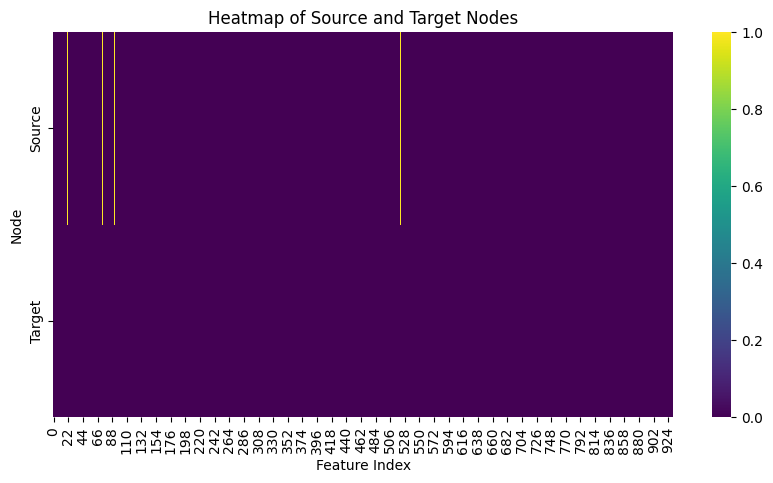

In [237]:
source_index = 6076
target_index = 6811

source = node_info.loc[source_index].values
target = node_info.loc[target_index].values

# Plot a heatmap of the source and target nodes

is_connected = data.loc[(data['source'] == source_index) & (data['target'] == target_index), 'label'].values[0]
print("Are the source and target nodes connected?", is_connected)
print("Number of 1s in source node:", source.sum())
print("Number of 1s in target node:", target.sum())
print("Indice of 1s in source node:", np.where(source == 1)[0])
print("Indice of 1s in target node:", np.where(target == 1)[0])
print("Shared keywords:", set(node_info.columns[source == 1]).intersection(set(node_info.columns[target == 1])))
print("Cosine similarity between the source and target nodes:", cosine_similarity([source], [target])[0][0])
print("Jaccard similarity between the source and target nodes:", len(set(node_info.columns[source == 1]).intersection(set(node_info.columns[target == 1])))/len(set(node_info.columns[source == 1]).union(set(node_info.columns[target == 1]))))

plt.figure(figsize=(10, 5))
sns.heatmap([source, target], cmap='viridis', yticklabels=['Source', 'Target'])
plt.title('Heatmap of Source and Target Nodes')
plt.xlabel('Feature Index')
plt.ylabel('Node')
plt.show()

In [129]:
def calculate_average_shared_keywords_by_label_excluding_top(data, node_info, exclude_indices=[]):
    """Calculate the average shared keywords between connected nodes, separated by label,
    excluding specific keyword positions.
    
    Args:
        data: DataFrame containing the edges and labels.
        node_info: DataFrame containing node features.
        exclude_indices: List of keyword index positions to exclude from the calculation.
        
    Returns:
        avg_linked: Average shared keywords for linked pairs, excluding specified indices.
        avg_not_linked: Average shared keywords for not-linked pairs, excluding specified indices.
    """
    avg_shared_keywords = {'linked': [], 'not_linked': []}

    for _, row in data.iterrows():
        source_keywords = node_info.loc[row['source']].values
        target_keywords = node_info.loc[row['target']].values
        
        # Mask to exclude specified indices
        mask = np.ones(len(source_keywords), dtype=bool)
        mask[exclude_indices] = False
        
        # Apply mask
        source_keywords_filtered = source_keywords[mask]
        target_keywords_filtered = target_keywords[mask]
        
        # Count shared keywords excluding specified positions
        shared_keywords = np.sum((source_keywords_filtered == 1) & (target_keywords_filtered == 1))
        
        if row['label'] == 1:
            avg_shared_keywords['linked'].append(shared_keywords)
        else:
            avg_shared_keywords['not_linked'].append(shared_keywords)
    
    avg_linked = np.mean(avg_shared_keywords['linked'])
    avg_not_linked = np.mean(avg_shared_keywords['not_linked'])
    
    return avg_linked, avg_not_linked

avg_linked, avg_not_linked = calculate_average_shared_keywords_by_label_excluding_top(data, node_info)
print(f"Average shared keywords in linked pairs: {avg_linked}")
print(f"Average shared keywords in not-linked pairs: {avg_not_linked}")


Average shared keywords in linked pairs: 0.8302210365853658
Average shared keywords in not-linked pairs: 0.8366996951219512


In [140]:
def calculate_average_cosine_similarity_excluding_top_k(data, node_info, mask=[]):
    """Calculate the average cosine similarity between node pairs, excluding specified keyword positions.
    
    Args:
        data: DataFrame containing node pairs and labels.
        node_info: DataFrame containing node features.
        k: The number of top frequent positions to exclude.
        exclude_indices: Precomputed list of indices to exclude. If None, will compute from data.
    
    Returns:
        The average cosine similarity for linked and unlinked pairs, excluding top k positions.
    """

    # Filter out the specified columns
    filtered_node_info = node_info.drop(columns=mask)
    
    # Compute cosine similarity for each pair
    avg_cosine_similarity = {'linked': [], 'not_linked': []}
    for _, row in data.iterrows():
        source_features = filtered_node_info.loc[row['source']].values.reshape(1, -1)
        target_features = filtered_node_info.loc[row['target']].values.reshape(1, -1)
        cosine_sim = cosine_similarity(source_features, target_features)[0][0]
        
        if row['label'] == 1:
            avg_cosine_similarity['linked'].append(cosine_sim)
        else:
            avg_cosine_similarity['not_linked'].append(cosine_sim)
    
    # Calculate the averages
    avg_linked = np.mean(avg_cosine_similarity['linked'])
    avg_not_linked = np.mean(avg_cosine_similarity['not_linked'])
    
    return avg_linked, avg_not_linked

avg_linked, avg_not_linked = calculate_average_cosine_similarity_excluding_top_k(data, node_info)
print(f"Average cosine similarity in linked pairs: {avg_linked}")
print(f"Average cosine similarity in not-linked pairs: {avg_not_linked}")

Average cosine similarity in linked pairs: 0.15878990955691746
Average cosine similarity in not-linked pairs: 0.16162035505984


In [128]:
def get_k_most_frequent_shared_keywords(data, node_info, k=5):
    """Find the k most frequent shared keyword positions from node pairs in the data DataFrame.
    
    Args:
        data: DataFrame containing the node pairs and labels.
        node_info: DataFrame containing node features with keyword positions.
        k: Number of top frequent shared keyword positions to return.
        
    Returns:
        A list of tuples, each containing a keyword position and its frequency among all node pairs, sorted by frequency.
    """
    shared_keyword_positions = []

    # Iterate over each row in the data to find shared keyword positions between each pair of nodes
    for index, row in data.iterrows():
        source_keywords = node_info.loc[row['source']].values
        target_keywords = node_info.loc[row['target']].values
        # Identify shared positions where both nodes have the keyword (value equals 1)
        shared_positions = np.where((source_keywords == 1) & (target_keywords == 1))[0]
        shared_keyword_positions.extend(shared_positions)

    # Use Counter to count the frequency of each shared keyword position
    position_counts = Counter(shared_keyword_positions)

    # Retrieve the k most common positions and their frequencies
    k_most_common = position_counts.most_common(k)

    return k_most_common

positive_edges = data[data['label'] == 1]
negative_edges = data[data['label'] == 0]

print("Top 5 most frequent shared keyword positions in positive edges:", get_k_most_frequent_shared_keywords(positive_edges, node_info))
print("Top 5 most frequent shared keyword positions in negative edges:", get_k_most_frequent_shared_keywords(negative_edges, node_info))

print("Top 20 most frequent shared keyword positions in the data:", get_k_most_frequent_shared_keywords(data, node_info, k=20))

Top 5 most frequent shared keyword positions in positive edges: [(92, 1469), (521, 1405), (138, 844), (132, 74), (369, 60)]
Top 5 most frequent shared keyword positions in negative edges: [(92, 1593), (521, 1456), (138, 872), (132, 63), (369, 57)]
Top 20 most frequent shared keyword positions in the data: [(92, 3062), (521, 2861), (138, 1716), (132, 137), (369, 117), (387, 78), (144, 45), (385, 44), (570, 29), (77, 29), (499, 29), (704, 28), (252, 28), (263, 28), (481, 27), (49, 26), (127, 25), (268, 24), (21, 21), (80, 18)]


In [259]:
mask = get_k_most_frequent_shared_keywords(data, node_info, k=100)

avg_linked, avg_not_linked = calculate_average_shared_keywords_by_label_excluding_top(data, node_info, exclude_indices=[x[0] for x in mask])
print("Average shared keywords in linked pairs (excluding top 50 positions):", avg_linked)
print("Average shared keywords in not-linked pairs (excluding 50 positions):", avg_not_linked)

avg_linked, avg_not_linked = calculate_average_cosine_similarity_excluding_top_k(data, node_info, mask=[x[0] for x in mask])
print("Average cosine similarity in linked pairs (excluding top 50 positions):", avg_linked)
print("Average cosine similarity in not-linked pairs (excluding 50 positions):", avg_not_linked)

Average shared keywords in linked pairs (excluding top 50 positions): 0.010670731707317074
Average shared keywords in not-linked pairs (excluding 50 positions): 0.004192073170731708
Average cosine similarity in linked pairs (excluding top 50 positions): 0.12478786317357651
Average cosine similarity in not-linked pairs (excluding 50 positions): 0.12627492169088708


In [143]:
def calculate_jaccard_coefficient(graph, pairs, node_info, exclude_indices=None):
    """Calculate the average Jaccard coefficient for a set of node pairs, optionally excluding certain indices.
    
    Args:
        graph: The graph containing nodes and edges.
        pairs: Iterable of node pairs (tuples or lists).
        node_info: DataFrame or similar structure with node features.
        exclude_indices: Indices of features to exclude in the calculation.
    
    Returns:
        A dictionary with the average Jaccard coefficients for linked and unlinked pairs.
    """
    jaccard_scores = {'linked': [], 'not_linked': []}
    
    for pair in pairs:
        source, target = pair
        source_features = set(np.where(node_info.loc[source].values == 1)[0])
        target_features = set(np.where(node_info.loc[target].values == 1)[0])
        
        # Apply mask if necessary
        if exclude_indices is not None:
            source_features -= set(exclude_indices)
            target_features -= set(exclude_indices)
        
        intersection = len(source_features & target_features)
        union = len(source_features | target_features)
        jaccard_score = intersection / union if union else 0
        
        if graph.has_edge(source, target):
            jaccard_scores['linked'].append(jaccard_score)
        else:
            jaccard_scores['not_linked'].append(jaccard_score)
    
    avg_jaccard_linked = np.mean(jaccard_scores['linked']) if jaccard_scores['linked'] else 0
    avg_jaccard_not_linked = np.mean(jaccard_scores['not_linked']) if jaccard_scores['not_linked'] else 0
    
    return {'avg_jaccard_linked': avg_jaccard_linked, 'avg_jaccard_not_linked': avg_jaccard_not_linked}

avg_jaccard_scores = calculate_jaccard_coefficient(G, data[['source', 'target']].values, node_info)
print("Average Jaccard coefficient for linked pairs:", avg_jaccard_scores['avg_jaccard_linked'])
print("Average Jaccard coefficient for not-linked pairs:", avg_jaccard_scores['avg_jaccard_not_linked'])

mask = [x[0] for x in get_k_most_frequent_shared_keywords(data, node_info, k=100)]
avg_jaccard_scores = calculate_jaccard_coefficient(G, data[['source', 'target']].values, node_info, exclude_indices=mask)
print("Average Jaccard coefficient for linked pairs (excluding top 50 positions):", avg_jaccard_scores['avg_jaccard_linked'])
print("Average Jaccard coefficient for not-linked pairs (excluding top 50 positions):", avg_jaccard_scores['avg_jaccard_not_linked'])


Average Jaccard coefficient for linked pairs: 0.09468104384263953
Average Jaccard coefficient for not-linked pairs: 0.0930849037124534
Average Jaccard coefficient for linked pairs (excluding top 50 positions): 0.003437563241297998
Average Jaccard coefficient for not-linked pairs (excluding top 50 positions): 0.0011643196991116649


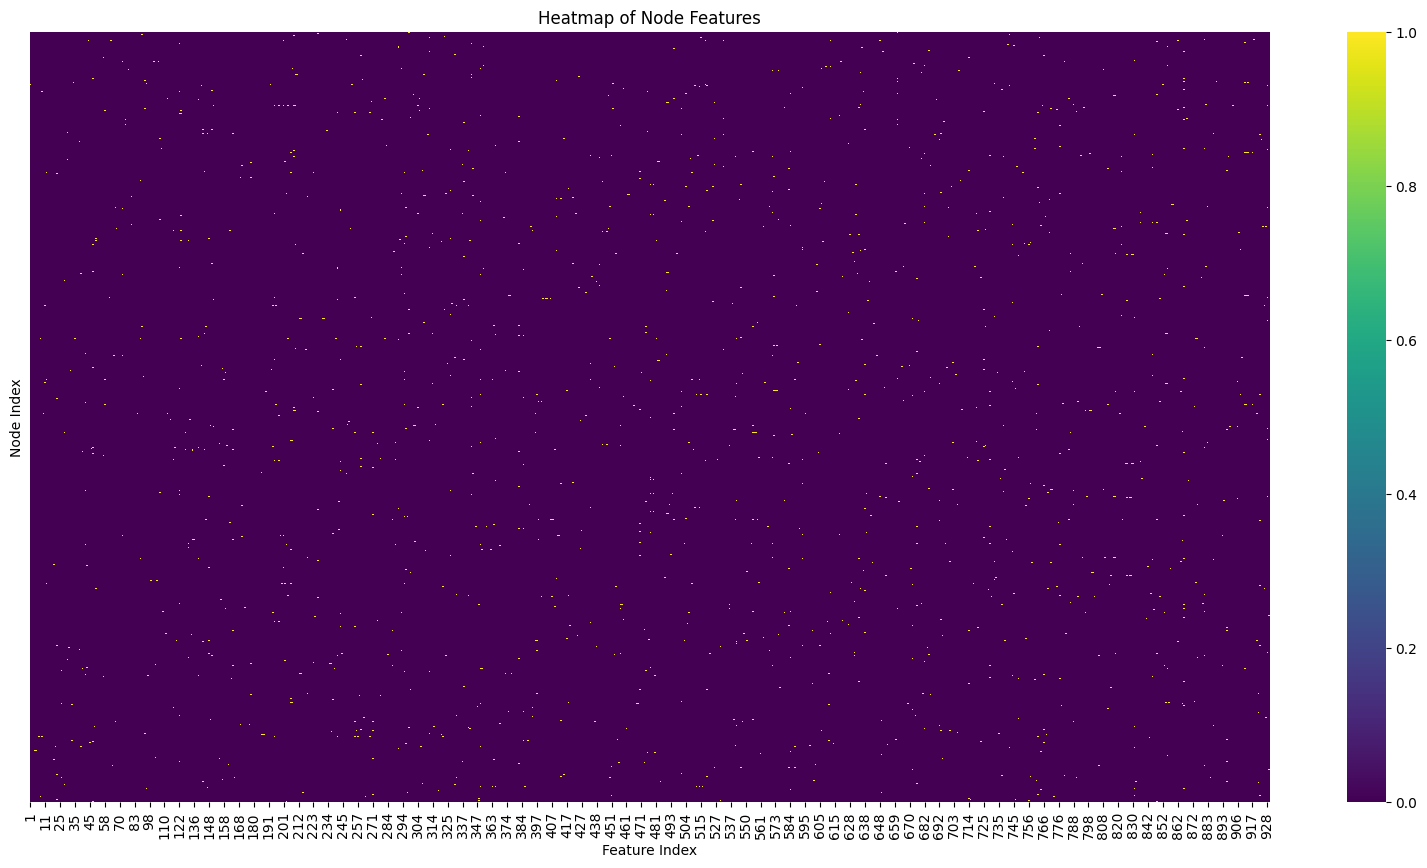

In [258]:
def plot_node_features_heatmap(node_info, exclude_indices=None):
    """Plot a heatmap of node features, excluding specified column indices.
    
    Args:
        node_info: DataFrame containing node features.
        exclude_indices: List of column indices to exclude from the heatmap. If None, all columns are included.
    """
    # If there are indices to exclude, drop these columns
    if exclude_indices is not None:
        filtered_node_info = node_info.drop(node_info.columns[exclude_indices], axis=1)
    else:
        filtered_node_info = node_info
    
    # Plotting the heatmap
    plt.figure(figsize=(20, 10))
    sns.heatmap(filtered_node_info, cmap='viridis', yticklabels=False)
    plt.title('Heatmap of Node Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Node Index')
    plt.show()

# Plot the heatmap of node features, excluding the top 20 most frequent shared keyword positions
top_20_shared_positions = [position for position, _ in get_k_most_frequent_shared_keywords(data, node_info, k=100)]

plot_node_features_heatmap(node_info, exclude_indices=top_20_shared_positions)

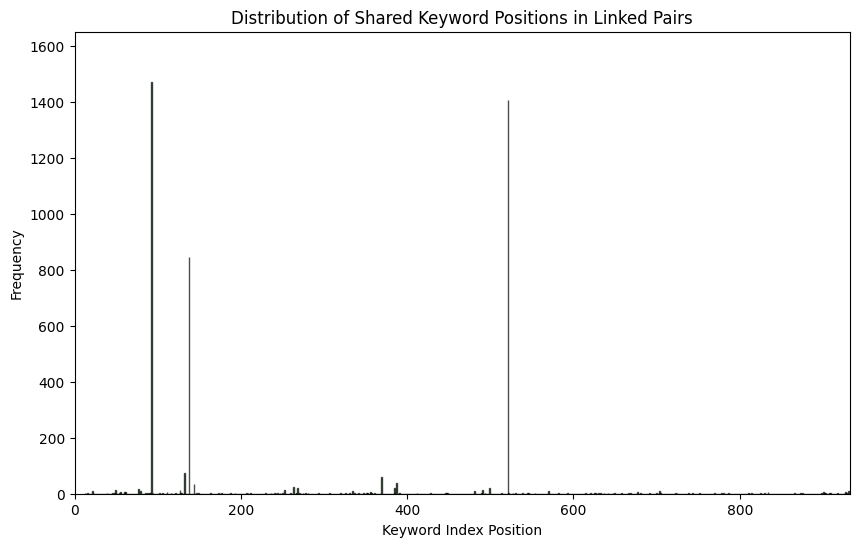

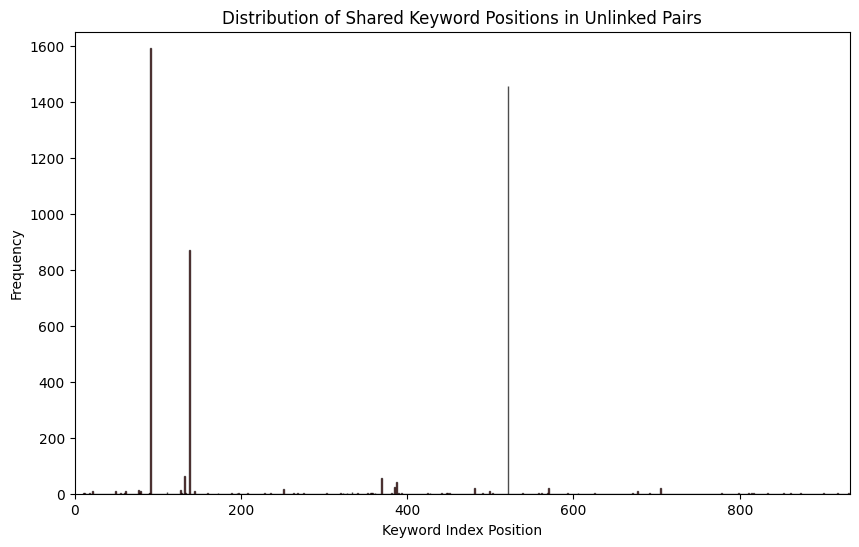

In [102]:
def visualize_shared_keywords_positions(data, node_info, linked=True, filter=False, k=int):
    """Visualize the index positions of shared keywords, with an option to exclude the top 5 most common positions.
    
    Args:
        data: DataFrame containing the edges and labels.
        node_info: DataFrame containing node features.
        linked: Boolean, True to visualize for linked pairs, False for unlinked pairs.
        filter: Boolean, True to exclude the top 20 most common shared keyword positions, False to include all.
    """
    shared_keyword_positions = []
    label_filter = 1 if linked else 0
    for source, target in data[data['label'] == label_filter][['source', 'target']].values:
        source_keywords = node_info.loc[source].values
        target_keywords = node_info.loc[target].values
        shared_positions = np.where((source_keywords == 1) & (target_keywords == 1))[0]
        shared_keyword_positions.extend(shared_positions)
    
    shared_positions_freq = pd.Series(shared_keyword_positions).value_counts()

    # Optionally filter out the top k most common positions
    if filter:
        top_keywords_indices = shared_positions_freq.head(k).index.tolist()
        filtered_keyword_positions = [pos for pos in shared_keyword_positions if pos not in top_keywords_indices]
        positions_to_plot = filtered_keyword_positions
    else:
        positions_to_plot = shared_keyword_positions
    
    plt.figure(figsize=(10, 6))
    color = 'green' if linked else 'red'
    title_part = 'Linked Pairs' if linked else 'Unlinked Pairs'
    filter_part = " (Excluding Top {})".format(k) if filter else ""
    title = f'Distribution of Shared Keyword Positions in {title_part}{filter_part}'
    plt.hist(positions_to_plot, bins=len(node_info.columns), alpha=0.7, color=color, edgecolor='black')
    plt.title(title)
    plt.xlabel('Keyword Index Position')
    plt.ylabel('Frequency')
    if not filter : 
        plt.xlim(0, len(node_info.columns))
        plt.ylim(0,1650)
    plt.show()
    


visualize_shared_keywords_positions(data, node_info, linked=True, filter=False, k=5)
visualize_shared_keywords_positions(data, node_info, linked=False, filter=False, k=5)

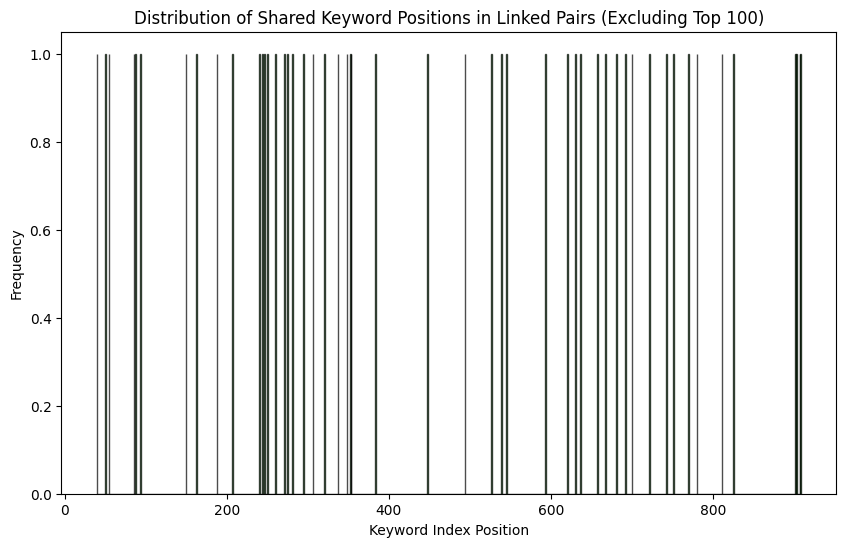

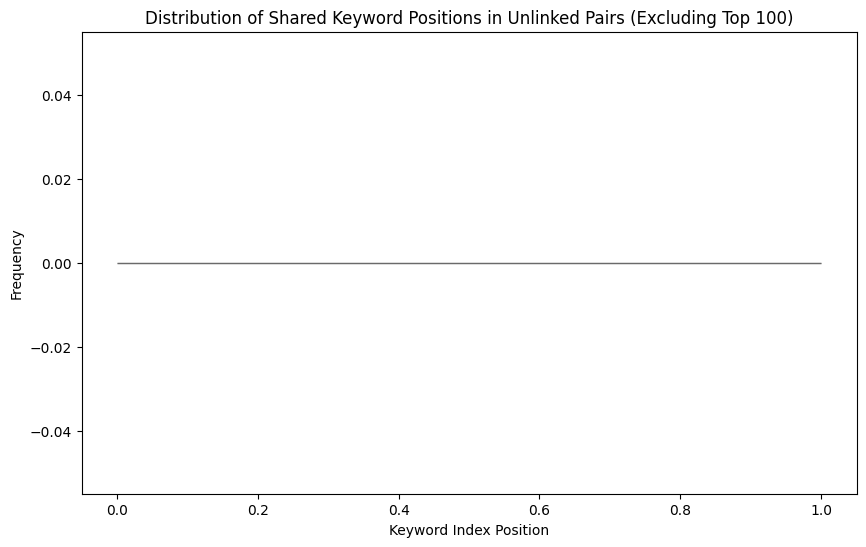

In [257]:
visualize_shared_keywords_positions(data, node_info, linked=True, filter=True, k=100)
visualize_shared_keywords_positions(data, node_info, linked=False, filter=True, k=100)

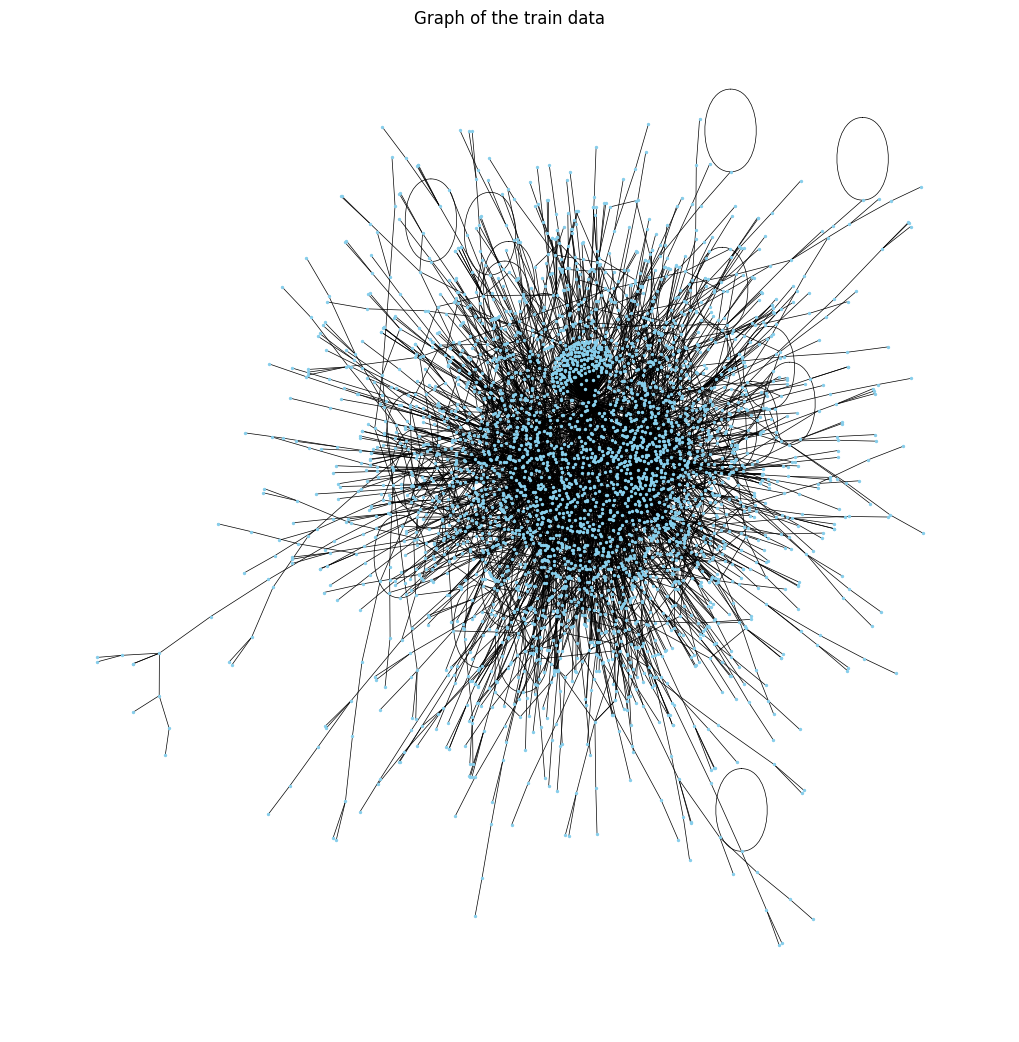

<Figure size 640x480 with 0 Axes>

In [156]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color='skyblue', node_size=2, with_labels=False, width=0.5)    
plt.title('Graph of the train data')
plt.show()
plt.tight_layout()


In [110]:
def compute_network_characteristics(graph):
    prop = {}
    prop['N'] = graph.number_of_nodes() # number of nodes
    prop['M'] = graph.number_of_edges() # number of edges
    degrees = [degree for node, degree in graph.degree()] # degree list
    prop['min_degree'] = np.min(degrees) # minimum degree
    prop['max_degree'] = np.max(degrees) # maximum degree
    prop['mean_degree'] = np.mean(degrees) # mean of node degrees
    prop['median_degree'] = np.median(degrees) # median of node degrees
    prop['density'] = nx.density(graph) # density of the graph
    return prop, degrees


prop, degrees = compute_network_characteristics(graph=G)
print("Number of nodes: {}".format(prop['N']))
print("Number of edges: {}".format(prop['M']))
print("Min. degree: {}".format(prop['min_degree']))
print("Max. degree: {}".format(prop['max_degree']))
print("Mean degree: {}".format(prop['mean_degree']))
print("Median degree: {}".format(prop['median_degree']))
print("Density: {}".format(prop['density']))

Number of nodes: 3597
Number of edges: 5248
Min. degree: 1
Max. degree: 361
Mean degree: 2.917987211565193
Median degree: 2.0
Density: 0.000811453618344047


#### Model Training and Validation

In [ ]:
def generate_samples(df, submission=False):
    """Split edges into training and testing sets, or prepare full training set for submission."""
    
    # Get rid of self-loops
    df = df[df['source'] != df['target']]

    positive_edges = df[df['label'] == 1][['source', 'target']].values
    negative_edges = df[df['label'] == 0][['source', 'target']].values
    
    #np.random.seed(42)  # Ensure reproducibility
    np.random.shuffle(positive_edges)
    np.random.shuffle(negative_edges)
    
    if submission:
        # Use all data for training when preparing for submission
        train_samples = np.concatenate((positive_edges, negative_edges))
        train_labels = np.array([1] * len(positive_edges) + [0] * len(negative_edges))
        return train_samples, train_labels
    else:
        # Split into training and testing sets for model evaluation
        total_pos_edges = len(positive_edges)
        train_pos_edges = positive_edges[:int(0.8 * total_pos_edges)]
        test_pos_edges = positive_edges[int(0.8 * total_pos_edges):]
        
        total_neg_edges = len(negative_edges)
        train_neg_edges = negative_edges[:int(0.8 * total_neg_edges)]
        test_neg_edges = negative_edges[int(0.8 * total_neg_edges):]
        
        train_samples = np.concatenate((train_pos_edges, train_neg_edges))
        test_samples = np.concatenate((test_pos_edges, test_neg_edges))
        
        train_labels = np.array([1] * len(train_pos_edges) + [0] * len(train_neg_edges))
        test_labels = np.array([1] * len(test_pos_edges) + [0] * len(test_neg_edges))
        
        return train_samples, train_labels, test_samples, test_labels



In [140]:
def feature_extractor_complete(graph, samples, node_info, exclude_indices=None):
    """Extracts features for each edge sample, adding more features like clustering coefficient,
    PageRank, neighborhood overlap, and text-based features using Node2Vec.
    """
    feature_vector = []

    # Compute centrality measures
    deg_centrality = nx.degree_centrality(graph)
    betweeness_centrality = nx.betweenness_centrality(graph)
    clustering_coeff = nx.clustering(graph)
    pagerank = nx.pagerank(graph)
    hub_score, authority_score = nx.hits(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph)
    load_centrality = nx.load_centrality(graph)  # Load centrality
    current_flow_closeness_centrality = nx.current_flow_closeness_centrality(graph)  # Current flow closeness centrality
    current_flow_betweenness_centrality = nx.current_flow_betweenness_centrality(graph)  # Current flow betweenness centrality
    harmonic_centrality = nx.harmonic_centrality(graph)  # Harmonic centrality

    for edge in tqdm(samples, desc='Extracting features'):
        source_node, target_node = edge[0], edge[1]

        # Extract node features, optionally excluding specific indices
        if exclude_indices is not None:
            source_features = np.delete(node_info.loc[source_node, :].values, exclude_indices)
            target_features = np.delete(node_info.loc[target_node, :].values, exclude_indices)
        else:
            source_features = node_info.loc[source_node].values
            target_features = node_info.loc[target_node].values

        # Text Similarity using dot product
        co_occurence_keyword = np.dot(source_features, target_features)

        # Continue with other feature calculations
        source_degree_centrality = deg_centrality[source_node]
        target_degree_centrality = deg_centrality[target_node]
        diff_bt = betweeness_centrality[target_node] - betweeness_centrality[source_node]
        common_neighbors = len(list(nx.common_neighbors(graph, source_node, target_node)))
        pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]
        aai = list(nx.adamic_adar_index(graph, [(source_node, target_node)]))[0][2]
        jacard_coeff = list(nx.jaccard_coefficient(graph, [(source_node, target_node)]))[0][2]
        source_clustering_coeff = clustering_coeff[source_node]
        target_clustering_coeff = clustering_coeff[target_node]
        source_pagerank = pagerank[source_node]
        target_pagerank = pagerank[target_node]
        neighborhood_overlap = len(set(graph.neighbors(source_node)) & set(graph.neighbors(target_node)))
        source_hub_score = hub_score[source_node]
        target_hub_score = hub_score[target_node]
        source_authority_score = authority_score[source_node]
        target_authority_score = authority_score[target_node]
        source_eigenvector_centrality = eigenvector_centrality[source_node]
        target_eigenvector_centrality = eigenvector_centrality[target_node]
        source_load_centrality = load_centrality[source_node]
        target_load_centrality = load_centrality[target_node]
        source_current_flow_closeness_centrality = current_flow_closeness_centrality[source_node]
        target_current_flow_closeness_centrality = current_flow_closeness_centrality[target_node]
        source_current_flow_betweenness_centrality = current_flow_betweenness_centrality[source_node]
        target_current_flow_betweenness_centrality = current_flow_betweenness_centrality[target_node]
        source_harmonic_centrality = harmonic_centrality[source_node]
        target_harmonic_centrality = harmonic_centrality[target_node]
        

        # Append the feature vector
        feature_vector.append([source_degree_centrality, target_degree_centrality, diff_bt, pref_attach, jacard_coeff,
                               source_clustering_coeff, target_clustering_coeff, source_pagerank, target_pagerank,
                               neighborhood_overlap, common_neighbors, co_occurence_keyword, source_hub_score,
                               target_hub_score, source_authority_score, target_authority_score, source_eigenvector_centrality, target_eigenvector_centrality,
                               source_load_centrality, target_load_centrality,
                               source_current_flow_closeness_centrality, target_current_flow_closeness_centrality,
                               source_current_flow_betweenness_centrality, target_current_flow_betweenness_centrality,
                               source_harmonic_centrality, target_harmonic_centrality, aai])

    return np.array(feature_vector)

Attention, on overfit avec trop de features, essayer step by step (approche bottom up par exemple)

In [141]:
train_samples, train_labels, test_samples, test_labels = generate_samples(data, submission=False)
#residual_g, train_samples, train_labels, test_samples, test_labels = generate_samples(G, 0.8)

train_features = feature_extractor_complete(G, train_samples, node_info)
test_features = feature_extractor_complete(G, test_samples, node_info)

Extracting features: 100%|██████████| 2094/2094 [00:00<00:00, 24378.38it/s]


In [12]:
# exclude_indices = get_k_most_frequent_shared_keywords(data, node_info, k=100)
# exclude_indices = [x[0] for x in exclude_indices]

# train_features_excl = feature_extractor(G, train_samples, node_info, exclude_indices)
# test_features_excl = feature_extractor(G, test_samples, node_info, exclude_indices)

In [142]:
def create_feature_df(samples, features, labels):
    """Create a DataFrame from the extracted features and labels."""
    feature_names = ['Degree Centrality Source', 'Degree Centrality Target', 'Betweenness Centrality Difference', 'Preferential Attachment', 'Jaccard Coefficient', 'Clustering Coefficient Source', 'Clustering Coefficient Target', 'PageRank Source', 'PageRank Target', 'Neighborhood Overlap', 'Common Neighbors', 'Co-occurence Keyword', 'Hub Score Source', 'Hub Score Target', 'Authority Score Source', 'Authority Score Target', 'Eigenvector Centrality Source', 'Eigenvector Centrality Target', 'Load Centrality Source', 'Load Centrality Target', 'Current Flow Closeness Centrality Source', 'Current Flow Closeness Centrality Target', 'Current Flow Betweenness Centrality Source', 'Current Flow Betweenness Centrality Target', 'Harmonic Centrality Source', 'Harmonic Centrality Target', 'Adamic-Adar Index']
    train_df = pd.DataFrame(features, columns=feature_names)    
    # train_df['source'] = samples[:, 0]
    # train_df['target'] = samples[:, 1]
    train_df['label'] = labels
    return train_df

In [143]:
feature_df = create_feature_df(train_samples, train_features, train_labels)
#feature_excl_df = create_feature_df(train_samples, train_features_excl, train_labels)

feature_df

,Degree Centrality Source,Degree Centrality Target,Betweenness Centrality Difference,Preferential Attachment,Jaccard Coefficient,Clustering Coefficient Source,Clustering Coefficient Target,PageRank Source,PageRank Target,Neighborhood Overlap,...,Load Centrality Source,Load Centrality Target,Current Flow Closeness Centrality Source,Current Flow Closeness Centrality Target,Current Flow Betweenness Centrality Source,Current Flow Betweenness Centrality Target,Harmonic Centrality Source,Harmonic Centrality Target,Adamic-Adar Index,label
0,0.001947,0.003337,0.000996,84.0,0.055556,0.047619,0.015152,0.000632,0.001019,1.0,...,0.004592,0.005596,0.000176,0.000192,8.762470e-03,1.579844e-02,771.983153,812.538756,1.442695,1
1,0.001390,0.005562,0.008306,100.0,0.000000,0.000000,0.013072,0.000405,0.001381,1.0,...,0.002164,0.010323,0.000179,0.000208,5.688103e-03,6.164464e-02,824.174784,823.304076,0.000000,1
2,0.002225,0.009177,0.006239,264.0,0.000000,0.000000,0.018939,0.000558,0.002261,0.0,...,0.012576,0.017808,0.000201,0.000215,1.032899e-02,3.131943e-02,985.928752,910.879978,0.000000,1
3,0.000278,0.002781,0.003160,10.0,0.000000,0.000000,0.022222,0.000103,0.000723,0.0,...,0.000000,0.003069,0.000115,0.000196,1.231175e-19,8.429225e-03,649.490185,808.968903,0.000000,1
4,0.005562,0.003059,-0.003641,220.0,0.000000,0.013072,0.018182,0.001381,0.000828,1.0,...,0.010323,0.007043,0.000208,0.000199,6.164464e-02,1.330328e-02,823.304076,854.186652,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8366,0.000556,0.000834,0.001084,6.0,0.000000,0.000000,0.000000,0.000198,0.000398,0.0,...,0.000040,0.001112,0.000127,0.000084,1.278946e-03,1.112192e-03,589.471542,587.465279,0.000000,0
8367,0.000556,0.000556,0.000556,4.0,0.000000,0.000000,0.000000,0.000236,0.000258,0.0,...,0.001112,0.001668,0.000110,0.000083,1.112038e-03,1.667592e-03,636.824109,580.137263,0.000000,0
8368,0.001390,0.000278,-0.002312,5.0,0.000000,0.000000,0.000000,0.000379,0.000103,0.0,...,0.002250,0.000000,0.000183,0.000115,6.026063e-03,1.231175e-19,771.144636,649.490185,0.000000,0
8369,0.000556,0.000556,-0.003689,4.0,0.000000,0.000000,0.000000,0.000206,0.000243,0.0,...,0.004841,0.001112,0.000125,0.000101,5.777102e-03,1.112038e-03,620.508225,718.481432,0.000000,0


In [165]:
def corr_matrix(df, exclude=False):
    """Plot a correlation matrix for the features."""
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)
    if exclude:
        plt.title('Correlation Matrix (Excluding Top 50 Positions)')
    else:
        plt.title('Correlation Matrix')

    # Plot the correlation with 'label' in descending order

    corr_with_label = corr['label'].sort_values(ascending=False).drop('label')
    plt.figure(figsize=(10, 5))
    print(corr['label'].sort_values(ascending=False).drop('label'))
    corr_with_label.plot(kind='bar', color='blue', edgecolor='black')
    plt.title('Correlation with Label')
    plt.xlabel('Feature')
    plt.ylabel('Correlation')
    plt.show()



Current Flow Closeness Centrality Target      0.457570
Harmonic Centrality Target                    0.352449
Current Flow Closeness Centrality Source      0.300158
Current Flow Betweenness Centrality Target    0.249461
Degree Centrality Target                      0.228915
PageRank Target                               0.220813
Load Centrality Target                        0.219996
Neighborhood Overlap                          0.211769
Betweenness Centrality Difference             0.199705
Current Flow Betweenness Centrality Source    0.196326
Eigenvector Centrality Target                 0.186785
Authority Score Target                        0.186784
Hub Score Target                              0.186784
Preferential Attachment                       0.180220
Harmonic Centrality Source                    0.178883
Common Neighbors                              0.175690
Adamic-Adar Index                             0.170046
Degree Centrality Source                      0.151834
PageRank S

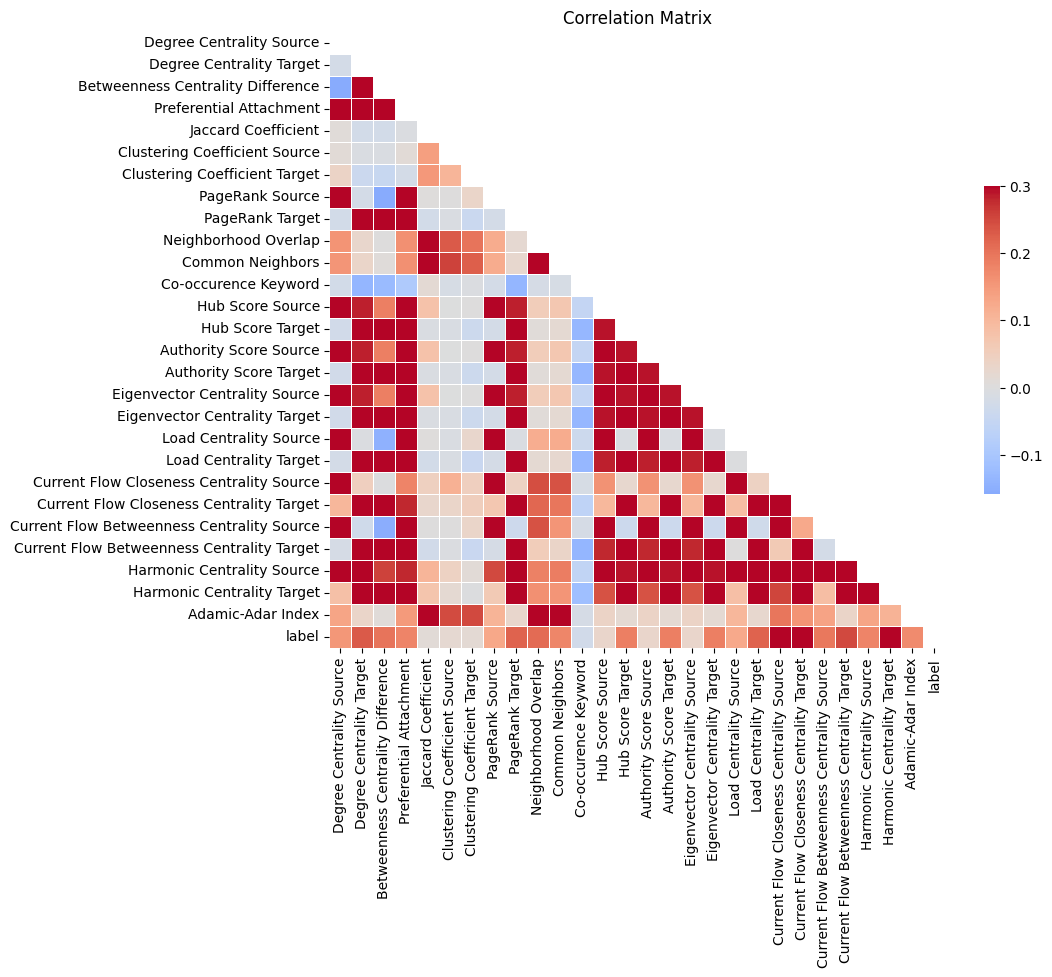

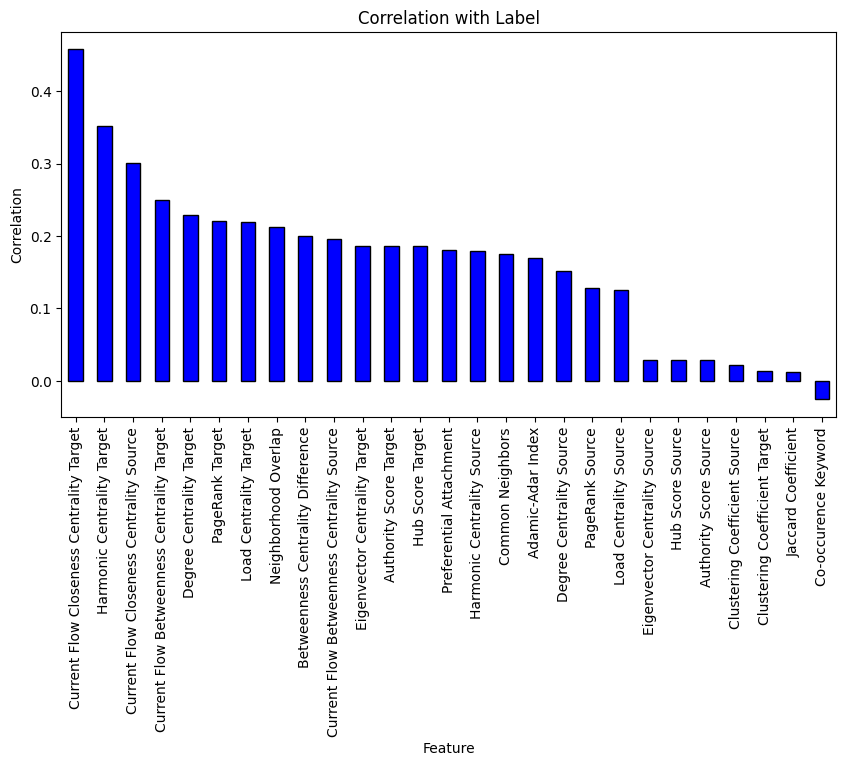

In [166]:
corr_matrix(feature_df)
#corr_matrix(feature_excl_df, exclude=True)


#### Define Classifier and Hyperparameter Space

#### Aplly PCA

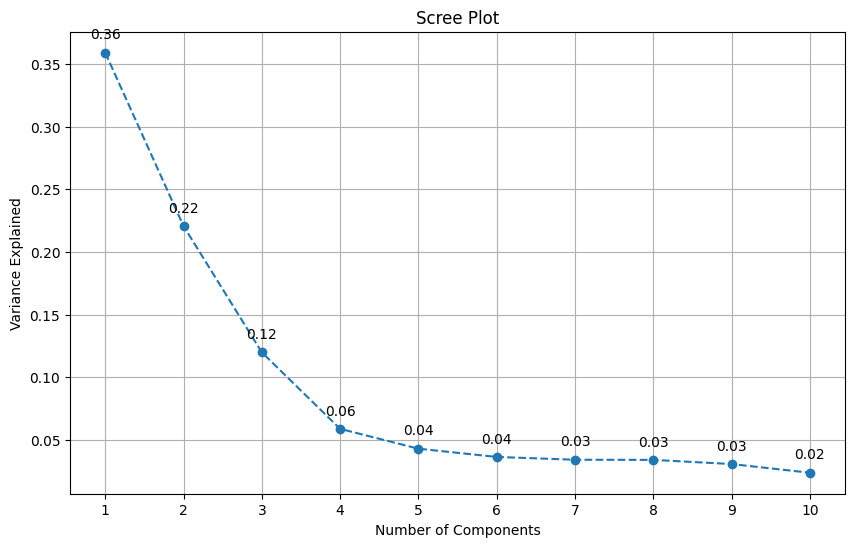

In [159]:
scaler = StandardScaler()

X = feature_df.drop(columns='label')
y = feature_df['label']

X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=10)
node_info_pca = pca.fit_transform(X_scaled) 

explained_variance = pca.explained_variance_ratio_


plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.xticks(np.arange(1, len(explained_variance) + 1))
plt.grid(True)

# Annotate each point with the percentage of variance it explains
for i, v in enumerate(explained_variance):
    label = f"{v:.2f}"
    plt.annotate(label, (i+1, v), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


##### XGBoost

In [147]:
# Scale the data

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Apply PCA to both training and testing features
pca = PCA(n_components=4)
train_features_pca = pca.fit_transform(train_features_scaled)
test_features_pca = pca.transform(test_features_scaled)

In [148]:
# Define XGB

clf_xgb = XGBClassifier(random_state=42)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid_xgb = {
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'max_depth': [3, 4, 7, 10, 15],
    'min_child_weight': [1,2,5,7,10],
    'gamma': [0.01, 0.1, 0.5],
    'subsample': [0.2, 0.6, 0.8],
    'colsample_bytree': [0.2, 0.6, 0.8],
    'reg_alpha': [0, 0.001, 0.005, 0.01],
    'reg_lambda': [0.0, 0.1, 1.0, 2.0]
}

search_xgb = RandomizedSearchCV(clf_xgb, param_grid_xgb, n_iter=20, cv=stratified_kfold, random_state=42, verbose=3)
search_xgb.fit(train_features_pca, train_labels)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=10, reg_alpha=0, reg_lambda=0.1, subsample=0.2;, score=0.737 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=10, reg_alpha=0, reg_lambda=0.1, subsample=0.2;, score=0.747 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=10, reg_alpha=0, reg_lambda=0.1, subsample=0.2;, score=0.728 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=10, reg_alpha=0, reg_lambda=0.1, subsample=0.2;, score=0.726 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.01, max_depth=3, min_child_weight=10, reg_alpha=0, reg_lambda=0.1, subsample=0.2;, score=0.743 total time=   0.1s
[CV 1/5] END colsample_bytree=0.2, gamma=0.01, learni

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importan...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': [0.2, 0.6, 0.8],
                                        'gamma': [0.01, 0.1, 0.5],
                                        'learning_rate': [0.005, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': [3, 4, 7, 10, 15],
                                        'min_child_weight': [1, 2, 5, 7, 10],
                                        'reg_alpha': [0, 0.001, 0.005, 0.01],
                                        'reg_lambda': [0.0, 0.1, 1.0, 2.0],
                                        'subsample': [0.2, 0.6, 0.8]},
                   random_state=42, verbose=3)

In [149]:
print("Best parameters found: ", search_xgb.best_params_)
print("Best score found: ", search_xgb.best_score_)
print("Best model: ", search_xgb.best_estimator_)
dump(search_xgb.best_estimator_, 'model/best_xgb_model.joblib')

Best parameters found:  {'subsample': 0.6, 'reg_lambda': 1.0, 'reg_alpha': 0.01, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best score found:  0.7701580270689563
Best model:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)


['model/best_xgb_model.joblib']

In [150]:
xgb_clf = load('model/best_xgb_model.joblib')
y_pred_xgb = xgb_clf.predict(test_features_pca)
print("Accuracy:", accuracy_score(test_labels, y_pred_xgb))

Accuracy: 0.7731614135625597


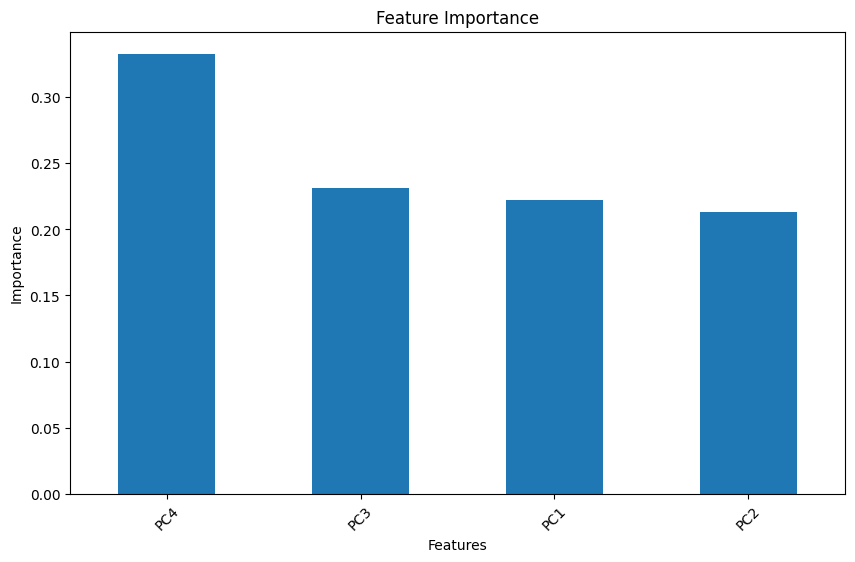

In [151]:
feature_names = ['Degree Centrality Source', 'Degree Centrality Target', 'Betweenness Centrality Difference', 'Preferential Attachment', 'Jaccard Coefficient', 'Clustering Coefficient Source', 'Clustering Coefficient Target', 'PageRank Source', 'PageRank Target', 'Neighborhood Overlap', 'Common Neighbors', 'Co-occurence Keyword', 'Hub Score Source', 'Hub Score Target', 'Authority Score Source', 'Authority Score Target', 'Eigenvector Centrality Source', 'Eigenvector Centrality Target', 'Load Centrality Source', 'Load Centrality Target', 'Current Flow Closeness Centrality Source', 'Current Flow Closeness Centrality Target', 'Current Flow Betweenness Centrality Source', 'Current Flow Betweenness Centrality Target', 'Harmonic Centrality Source', 'Harmonic Centrality Target']
feature_names_pca = [f'PC{i+1}' for i in range(4)]

importance = xgb_clf.feature_importances_
importance_series = pd.Series(importance, index=feature_names_pca)

# Sort the feature importances
sorted_importance = importance_series.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sorted_importance.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

##### Random Forest

In [112]:
# Scale the data

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

In [112]:
# Define XGB

clf_rf = RandomForestClassifier(random_state=42)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid_rf = {
    'n_estimators': [10, 20, 50, 80],
    'max_depth': [2, 5, 8, 10, 20],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 2, 4]
}


search_rf = RandomizedSearchCV(clf_rf, param_grid_rf, n_iter=20, cv=stratified_kfold, random_state=42, verbose=3)
search_rf.fit(train_features_pca, train_labels)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=80;, score=0.736 total time=   0.2s
[CV 2/5] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=80;, score=0.724 total time=   0.2s
[CV 3/5] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=80;, score=0.730 total time=   0.2s
[CV 4/5] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=80;, score=0.738 total time=   0.2s
[CV 5/5] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=80;, score=0.739 total time=   0.2s
[CV 1/5] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.754 total time=   0.2s
[CV 2/5] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.741 total time=   0.2s
[CV 3/5] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.746 total time=   0.2s
[C

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_iter=20,
                   param_distributions={'max_depth': [2, 5, 8, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [5, 10, 15],
                                        'n_estimators': [10, 20, 50, 80]},
                   random_state=42, verbose=3)

In [113]:
print("Best parameters found: ", search_rf.best_params_)
print("Best score found: ", search_rf.best_score_)
print("Best model: ", search_rf.best_estimator_)
dump(search_rf.best_estimator_, 'model/best_rf_model.joblib')

Best parameters found:  {'n_estimators': 80, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20}
Best score found:  0.7862076349300888
Best model:  RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=80, random_state=42)


['model/best_rf_model.joblib']

In [114]:
rf_clf = load('model/best_rf_model.joblib')
y_pred_rf = rf_clf.predict(test_features_pca)
print("Accuracy:", accuracy_score(test_labels, y_pred_rf))

Accuracy: 0.7852380952380953


##### Logistic Regression

In [120]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

In [115]:
# Define XGB

clf_lr = LogisticRegression(max_iter=10000, random_state=42)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid_lr = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}


search_lr = RandomizedSearchCV(clf_lr, param_grid_lr, n_iter=20, cv=stratified_kfold, verbose=3)
search_lr.fit(train_features_pca, train_labels)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.733 total time=   0.0s
[CV 2/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.734 total time=   0.0s
[CV 3/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.732 total time=   0.0s
[CV 4/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.736 total time=   0.0s
[CV 5/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.727 total time=   0.0s
[CV 1/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.730 total time=   0.0s
[CV 2/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.736 total time=   0.0s
[CV 3/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.728 total time=   0.0s
[CV 4/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.731 total time=   0.0s
[CV 5/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.719 total time=   0.0s
[CV 1/5] END C=0.1, penalty=l1, solver=liblinear;, score=0.729 total time=   0.0s
[CV 2/5] END C=0.1, penalty=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LogisticRegression(max_iter=10000,
                                                random_state=42),
                   n_iter=20,
                   param_distributions={'C': [0.01, 0.1, 1.0, 10.0],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear']},
                   verbose=3)

In [116]:
print("Best parameters found: ", search_lr.best_params_)
print("Best score found: ", search_lr.best_score_)
print("Best model: ", search_lr.best_estimator_)
dump(search_lr.best_estimator_, 'model/best_lr_model.joblib')

Best parameters found:  {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.01}
Best score found:  0.7322533253920984
Best model:  LogisticRegression(C=0.01, max_iter=10000, penalty='l1', random_state=42,
                   solver='liblinear')


['model/best_lr_model.joblib']

In [118]:
search_lr = load('model/best_lr_model.joblib')
y_pred_lr = search_lr.predict(test_features_pca)
print("Accuracy:", accuracy_score(test_labels, y_pred_lr))

Accuracy: 0.7166666666666667


##### SVC

In [124]:
# Scale the data

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

In [120]:
clf_svc = SVC(probability=True, random_state=42)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'coef0': [0.0, 0.1, 0.5]
}

search_svc = RandomizedSearchCV(clf_svc, param_grid_svc, n_iter=3, cv=stratified_kfold, verbose=3)
search_svc.fit(train_features_pca, train_labels)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .......C=10, coef0=0.0, kernel=rbf;, score=0.750 total time=   2.7s
[CV 2/5] END .......C=10, coef0=0.0, kernel=rbf;, score=0.748 total time=   2.8s
[CV 3/5] END .......C=10, coef0=0.0, kernel=rbf;, score=0.742 total time=   2.7s
[CV 4/5] END .......C=10, coef0=0.0, kernel=rbf;, score=0.757 total time=   2.8s
[CV 5/5] END .......C=10, coef0=0.0, kernel=rbf;, score=0.753 total time=   2.7s
[CV 1/5] END ......C=0.1, coef0=0.5, kernel=rbf;, score=0.745 total time=   2.6s
[CV 2/5] END ......C=0.1, coef0=0.5, kernel=rbf;, score=0.734 total time=   2.6s
[CV 3/5] END ......C=0.1, coef0=0.5, kernel=rbf;, score=0.731 total time=   2.5s
[CV 4/5] END ......C=0.1, coef0=0.5, kernel=rbf;, score=0.746 total time=   2.6s
[CV 5/5] END ......C=0.1, coef0=0.5, kernel=rbf;, score=0.742 total time=   2.6s
[CV 1/5] END ......C=100, coef0=0.0, kernel=rbf;, score=0.757 total time=   3.4s
[CV 2/5] END ......C=100, coef0=0.0, kernel=rbf;,

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=SVC(probability=True, random_state=42), n_iter=3,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'coef0': [0.0, 0.1, 0.5],
                                        'kernel': ['linear', 'rbf']},
                   verbose=3)

In [121]:
print("Best parameters found: ", search_svc.best_params_)
print("Best score found: ", search_svc.best_score_)
print("Best model: ", search_svc.best_estimator_) 
dump(search_svc.best_estimator_, 'model/best_svc_model.joblib')

Best parameters found:  {'kernel': 'rbf', 'coef0': 0.0, 'C': 100}
Best score found:  0.7546448424515726
Best model:  SVC(C=100, probability=True, random_state=42)


['model/best_svc_model.joblib']

In [123]:
search_svc = load('model/best_svc_model.joblib')
y_pred_svc = search_svc.predict(test_features_pca)
print("Accuracy:", accuracy_score(test_labels, y_pred_svc))

Accuracy: 0.7438095238095238


#### Stacking & Ensemble

In [160]:
clf_lr = load('model/best_lr_model.joblib')
clf_svc = load('model/best_svc_model.joblib')
clf_rf = load('model/best_rf_model.joblib')
clf_xgb = load('model/best_xgb_model.joblib')

In [163]:
# Print best parameters for each model
print("Logistic Regression: ", clf_lr)
print("Support Vector Classifier: ", clf_svc)
print("Random Forest: ", clf_rf)
print("XGBoost: ", clf_xgb)


Logistic Regression:  LogisticRegression(C=0.01, max_iter=10000, penalty='l1', random_state=42,
                   solver='liblinear')
Support Vector Classifier:  SVC(C=100, probability=True, random_state=42)
Random Forest:  RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=80, random_state=42)
XGBoost:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
          

In [24]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

In [131]:
# Implement the list of estimators.

estimators = [
    ('lr', clf_lr),
    ('svc', clf_svc),
    ('rf', clf_rf),
    ('xgb', clf_xgb)
]

# Compute all individual scores

for clf, label in zip([clf_rf, clf_xgb], ['Random Forest', 'XGBoost']):
    clf.fit(train_features_pca, train_labels)
    y_pred = clf.predict(test_features_pca)
    print(f"Accuracy for {label}: {accuracy_score(test_labels, y_pred)}")

# Voting Classifier
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

voting_clf.fit(train_features_pca, train_labels)

y_pred = voting_clf.predict(test_features_pca)
print(f"Accuracy for Voting Classifier: {accuracy_score(test_labels, y_pred)}")

Accuracy for Random Forest: 0.7852380952380953
Accuracy for XGBoost: 0.770952380952381
Accuracy for Voting Classifier: 0.7461904761904762


#### Final Model and Predictions

In [167]:
test_data = pd.read_csv('data/test.txt', sep=' ', header=None, names=['source', 'target'])

# Remove self loop from test_data
test_data_corrected = test_data[test_data['source'] != test_data['target']]

# Identify self-loop edges
self_loop_indices = test_data[test_data['source'] == test_data['target']].index

# Extract the self-loop edges for later inclusion
self_loop_edges = test_data.loc[self_loop_indices]

In [155]:
train_samples, train_labels = generate_samples(data, submission=True)
train_features = feature_extractor_complete(G, train_samples, node_info)

#residual_g, train_samples, train_labels = generate_samples(G, 1.0)
#train_features = feature_extractor(G, train_samples, node_info)

# Scale the data
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)

# Apply PCA to both training and testing features
pca = PCA(n_components=4)
train_features_pca = pca.fit_transform(train_features_scaled)


# Fit the voting classifier
voting_clf = VotingClassifier(estimators=estimators, voting='soft')
voting_clf.fit(train_features_pca, train_labels)

# clf_xgb.fit(train_features_pca, train_labels)

test_features = feature_extractor_complete(G, test_data_corrected.values, node_info)
test_features_scaled = scaler.transform(test_features)
test_features_pca = pca.transform(test_features_scaled)

test_preds = voting_clf.predict(test_features_pca)

# Prepare the submission file without self-loop edges
submission = pd.DataFrame({'ID': test_data_corrected.index, 'Predicted': test_preds})

# Reinsert self-loop edges into the predictions
self_loop_edges_submission = pd.DataFrame({'ID': self_loop_edges.index, 'Predicted': 0})
submission = pd.concat([submission, self_loop_edges_submission])

# Sort submission by index
submission.sort_values(by='ID',inplace=True)

# Save the submission file
submission.to_csv('submission/submission.csv', index=False)

Extracting features: 100%|██████████| 3481/3481 [00:00<00:00, 24425.71it/s]
